In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import collections
import pandas as pd

from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, classification_report # 정오분류표
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score,classification_report,confusion_matrix  # ROC곡선 그리기
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.model_selection import learning_curve, validation_curve # 학습곡선, 검증곡선
from sklearn.model_selection import GridSearchCV, cross_val_score  # 하이퍼파라미터 튜닝, 교차타당도

In [2]:
%matplotlib inline
import os

from xgboost import plot_tree

import matplotlib.pyplot as plt

from matplotlib.pylab import rcParams

In [3]:
import shap
from xgboost import plot_importance

# Data Load

In [4]:
origin_df = pd.read_csv("data/newquant_samsung.csv",index_col=['Date'],parse_dates=True)

In [5]:
origin_df.describe()

,Open,High,Low,Close,Adj Close,Volume,S&P500,SOX,VIX,KOSPI,...,WPR60,WPR90,ADXR14,ADXR30,ADXR60,ADXR90,ADX14,ADX30,ADX60,ADX90
count,4144.000000,4144.000000,4144.000000,4144.000000,4144.000000,4.144000e+03,4019.000000,4018.000000,4019.000000,4124.000000,...,4085.000000,4055.000000,4104.000000,4056.000000,3966.000000,3876.000000,4117.000000,4085.000000,4025.000000,3965.000000
mean,28728.766892,29018.928571,28434.971042,28725.979730,25346.247004,1.764276e+07,1905.969651,825.286612,19.154830,1908.795439,...,-44.496581,-43.018261,21.966906,15.005289,10.297370,8.082934,21.983842,15.005888,10.325811,8.211978
std,18379.716108,18549.246492,18215.098324,18372.217182,18438.687639,9.425518e+06,828.862213,700.595768,9.359856,453.467496,...,30.371038,29.780829,7.063173,5.065611,3.802997,3.014785,8.088642,5.705662,4.304796,3.583203
min,8150.000000,8630.000000,8040.000000,8040.000000,6359.822266,0.000000e+00,676.530029,171.320007,9.140000,870.840027,...,-100.000000,-100.000000,9.109386,6.494768,4.382940,4.292340,7.330786,5.576254,3.768456,3.456301
25%,13220.000000,13400.000000,13115.000000,13220.000000,10321.984863,1.092296e+07,1271.489990,399.242508,13.120000,1661.219971,...,-70.987654,-68.802542,16.529336,11.431915,7.868138,6.175791,15.793819,10.844827,7.435900,5.889298
50%,25200.000000,25420.000000,24930.000000,25170.000000,21032.793945,1.534330e+07,1563.770020,500.110001,16.330000,1958.994995,...,-41.538462,-39.130435,20.850215,14.106751,9.311304,7.211848,20.382015,13.908429,9.306758,7.205247
75%,42000.000000,42470.000000,41725.000000,42150.000000,38430.722656,2.180545e+07,2427.900024,1077.652527,22.129999,2087.907410,...,-16.216216,-15.604708,26.105242,17.672525,11.670401,8.911308,27.092232,17.846087,11.810654,9.051516
max,90300.000000,96800.000000,89500.000000,91000.000000,90198.078125,9.030618e+07,4536.950195,3473.600098,82.690002,3305.209961,...,-0.000000,-0.000000,53.962040,36.400009,25.403293,19.845878,60.136137,41.302126,26.643279,21.219039


In [6]:
origin_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4144 entries, 2005-01-04 to 2021-09-17
Data columns (total 58 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          4144 non-null   float64
 1   High          4144 non-null   float64
 2   Low           4144 non-null   float64
 3   Close         4144 non-null   float64
 4   Adj Close     4144 non-null   float64
 5   Volume        4144 non-null   int64  
 6   S&P500        4019 non-null   float64
 7   SOX           4018 non-null   float64
 8   VIX           4019 non-null   float64
 9   KOSPI         4124 non-null   float64
 10  kosATR14      4124 non-null   float64
 11  kosATR30      4124 non-null   float64
 12  kosATR60      4124 non-null   float64
 13  kosATR90      4124 non-null   float64
 14  kosADX14      4124 non-null   float64
 15  kosADX30      4124 non-null   float64
 16  kosADX60      4124 non-null   float64
 17  kosADX90      4124 non-null   float64
 18  log_return

In [7]:
n_list = [1,3,5,7,10,20,30,60,90]
for n in n_list:
    col_name = 'avg_price'+str(n)

    origin_df[col_name] = origin_df['Close'].rolling(window=n).mean()
    origin_df[col_name] = origin_df[col_name].shift(-n)
    # shift -n이면 해당일 제외 , shift -n-1이면 해당일 포함한 평균이다.
    diffs = origin_df[col_name]-origin_df['Close']
    label_name = 'label'+str(n)
    origin_df[label_name] = np.where(diffs>0,1,0)
    

# setting
df = origin_df['2011-01-01':'2020-12-31']
df.dropna(inplace=True)



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'S&P500', 'SOX',
       'VIX', 'KOSPI', 'kosATR14', 'kosATR30', 'kosATR60', 'kosATR90',
       'kosADX14', 'kosADX30', 'kosADX60', 'kosADX90', 'log_return', 'CCI',
       'MA5', 'MA10', 'MA20', 'MA60', 'MA20_ratio', 'MA60_ratio',
       'MA20_volume', 'MA60_volumne', 'RASD5', 'RASD10', 'MACD', 'CCI14',
       'CCI30', 'CCI60', 'ATR14', 'ATR30', 'ATR60', 'ATR90', 'ub', 'middle',
       'lb', 'MTM1', 'MTM3', 'MTM6', 'ROC60', 'ROC90', 'WPR14', 'WPR30',
       'WPR60', 'WPR90', 'ADXR14', 'ADXR30', 'ADXR60', 'ADXR90', 'ADX14',
       'ADX30', 'ADX60', 'ADX90', 'avg_price1', 'label1', 'avg_price3',
       'label3', 'avg_price5', 'label5', 'avg_price7', 'label7', 'avg_price10',
       'label10', 'avg_price20', 'label20', 'avg_price30', 'label30',
       'avg_price60', 'label60', 'avg_price90', 'label90'],
      dtype='object')

# feature

In [9]:
# 가격데이터
feature1_list = ['Open','High','Low','Adj Close','Volume','log_return','Close']
# 기술지표 데이터
feature2_list = ['MA5', 'MA10', 'MA20', 'MA60',
       'MA20_ratio', 'MA60_ratio', 'MA20_volume', 'MA60_volumne', 'RASD5',
       'RASD10', 'MACD', 'CCI14', 'CCI30', 'CCI60', 'ATR14', 'ATR30', 'ATR60',
       'ATR90', 'ub', 'middle', 'lb', 'MTM1', 'MTM3', 'MTM6', 'ROC60', 'ROC90',
       'WPR14', 'WPR30', 'WPR60', 'WPR90', 'ADX14', 'ADX30', 'ADX60', 'ADX90',
                'ADXR14', 'ADXR30', 'ADXR60', 'ADXR90']
# 시장지표 데이터
feature3_list = [#'S&P500', 'SOX', 'VIX','KOSPI',
    'kosATR14',
       'kosATR30', 'kosATR60', 'kosATR90', 'kosADX14', 'kosADX30', 'kosADX60',
       'kosADX90']
# 라벨링에 사용할 데이터
feature4_list = ['next_price','next_rtn']
# 기술지표 중 가격 정보가 덜 드러나는 데이터 
feature5_list = ['CCI14', 'CCI30', 'CCI60', 'ATR14', 'ATR30', 'ATR60',
       'MTM1', 'MTM3', 'MTM6', 'ROC60', 'ROC90',
       'WPR14', 'WPR30', 'WPR60', 'WPR90', 'ADX14', 'ADX30', 'ADX60', 'ADX90',
                'ADXR14', 'ADXR30', 'ADXR60', 'ADXR90']
# 기술지표 중 가격 정보가 드러나는 데이터
feature6_list = ['MA5', 'MA10', 'MA20', 'MA60',
       'MA20_ratio', 'MA60_ratio', 'MA20_volume', 'MA60_volumne', 'RASD5',
       'RASD10']

final_feature = ['kosADX14', 'kosADX30', 'kosADX60','kosADX90'
                 ,'CCI30', 'CCI60'
                 ,'MTM1', 'MTM3'
                 ,'ROC60', 'ROC90'
                 ,'WPR60', 'WPR90'
                 ,'ADX14', 'ADX30', 'ADX60', 'ADX90',
                'ADXR14', 'ADXR30', 'ADXR60', 'ADXR90']
all_x_feature = feature1_list+feature2_list+feature3_list

## 사용한 변수

In [10]:
for r in final_feature:
    print(r,end=', ')

print(len(final_feature))

kosADX14, kosADX30, kosADX60, kosADX90, CCI30, CCI60, MTM1, MTM3, ROC60, ROC90, WPR60, WPR90, ADX14, ADX30, ADX60, ADX90, ADXR14, ADXR30, ADXR60, ADXR90, 20


# 예측 함수 정의

In [11]:
n = 30
featurelist = final_feature


result = pd.DataFrame(columns=['label','acc'])

labels = []
accs = []
X = df[featurelist]

# Min Max Scaler를 사용해 스케일링
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

for n in n_list:
    label_name = 'label'+str(n)
    y = df[label_name]

    # train test split
    # label별로 비교하기위해 startify x
    X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,stratify=y, test_size=0.2, random_state=1234)
    #print('Lable'+str(n)+' 양성비율','train : %.3f' %(sum(y_train)/len(y_train)),end=' ')
    #print('test : %.3f' %(sum(y_test)/len(y_test)),end='\t')


    model = XGBClassifier(learning_rate= 0.3, 
                      max_depth= 6, 
                      n_estimators= 110,
                       booster='gbtree',
                        objective='binary:logistic',
                      feature_names = X.columns.to_list())
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)


    labels.append(label_name)
    acc = round(accuracy_score(y_test, y_pred) * 100,2)
    accs.append(acc)

result['label'] = labels
result['acc'] = accs


[20:30:08] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { feature_names } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:30:08] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[20:30:08] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { feature_names } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:30:08] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[20:30:08] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { feature_names } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:30:08] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[20:30:09] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { feature_names } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:30:09] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[20:30:09] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { feature_names } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:30:09] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[20:30:09] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { feature_names } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:30:09] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[20:30:09] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { feature_names } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:30:09] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[20:30:09] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { feature_names } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:30:09] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:10] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { feature_names } might not be u

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


## prediction result

In [12]:
result

,label,acc
0,label1,52.52
1,label3,69.96
2,label5,76.47
3,label7,80.88
4,label10,86.55
5,label20,91.60
6,label30,91.60
7,label60,95.17
8,label90,96.85


# XAI 기법 적용

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[20:30:10] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { feature_names } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:30:10] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


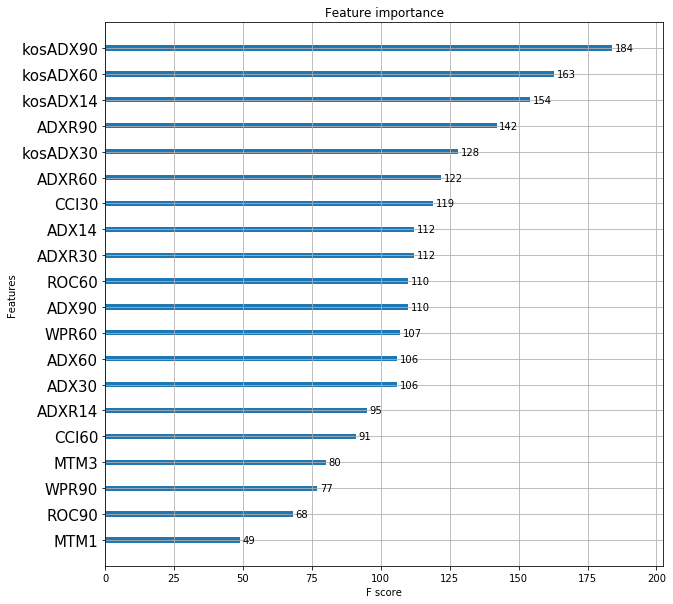

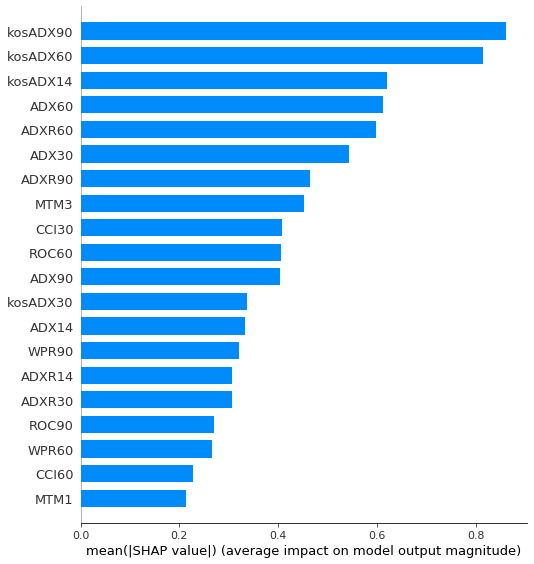

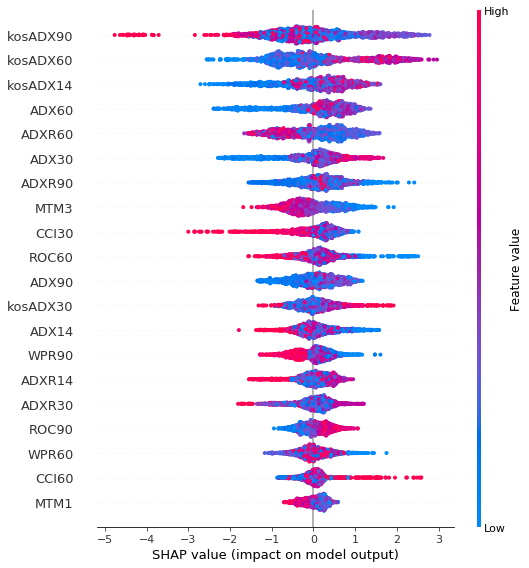

In [13]:
result = pd.DataFrame(columns=['label','acc'])

labels = []
accs = []
X = df[featurelist]

# Min Max Scaler를 사용해 스케일링
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)


label_name = 'label30'
y = df[label_name]

# train test split
# label별로 비교하기위해 startify x
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,stratify=y, test_size=0.2, random_state=1234)
#print('Lable'+str(n)+' 양성비율','train : %.3f' %(sum(y_train)/len(y_train)),end=' ')
#print('test : %.3f' %(sum(y_test)/len(y_test)),end='\t')


model = XGBClassifier(learning_rate= 0.3, 
                      max_depth= 6, 
                      n_estimators= 110,
                       booster='gbtree',
                        objective='binary:logistic',
                      feature_names = X.columns.to_list()
                     ,random_state=1234)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)


from xgboost import plot_importance


rcParams['figure.figsize'] = 10,10

model.get_booster().feature_names = X.columns.tolist()
plot_importance(model)

plt.yticks(fontsize = 15)
plt.show()

# JS 시각화 라이브러리 로드하기
shap.initjs()

# SHAP 값으로 모델의 예측을 설명하기
# 설명체는 LightGBM, CATBoost, scikit-learn 모델을 입력받을 수 있다.

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values,X_train, plot_type='bar',feature_names = X.columns.tolist())

# 모든 피처에 대해 SHAP 값을 계산하고, 영향력을 시각화하는 코드
shap.summary_plot(shap_values, X_train,feature_names = X.columns.tolist())

In [14]:
df1 = X.copy()
df1['trend'] = y


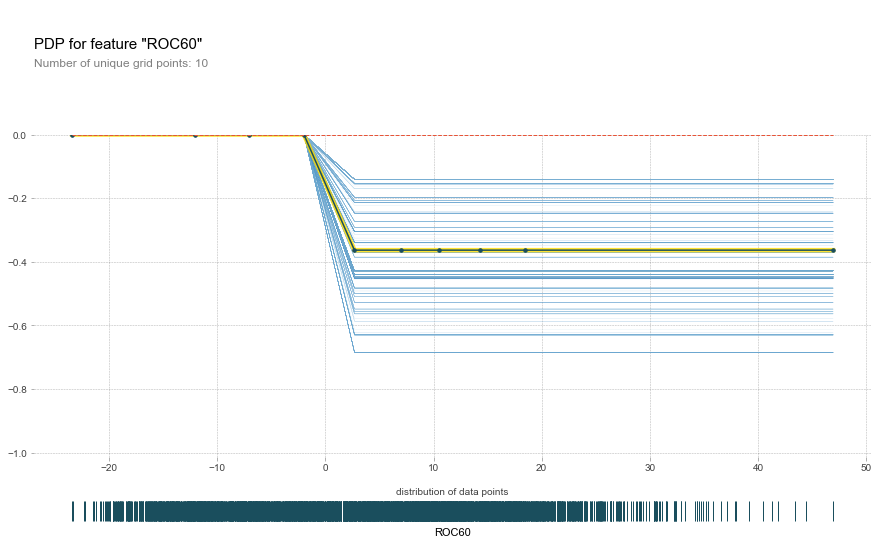

In [15]:
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox import pdp

pdp_gc = pdp.pdp_isolate(
        model = model,
        dataset = df1,
        model_features = X.columns.tolist(),
        feature= 'ROC60'
)

# 플롯 정보 설정
fig, axes = pdp.pdp_plot(
        pdp_gc,
        'ROC60',
        plot_lines = True,
        frac_to_plot = 0.5,
        plot_pts_dist=True
)

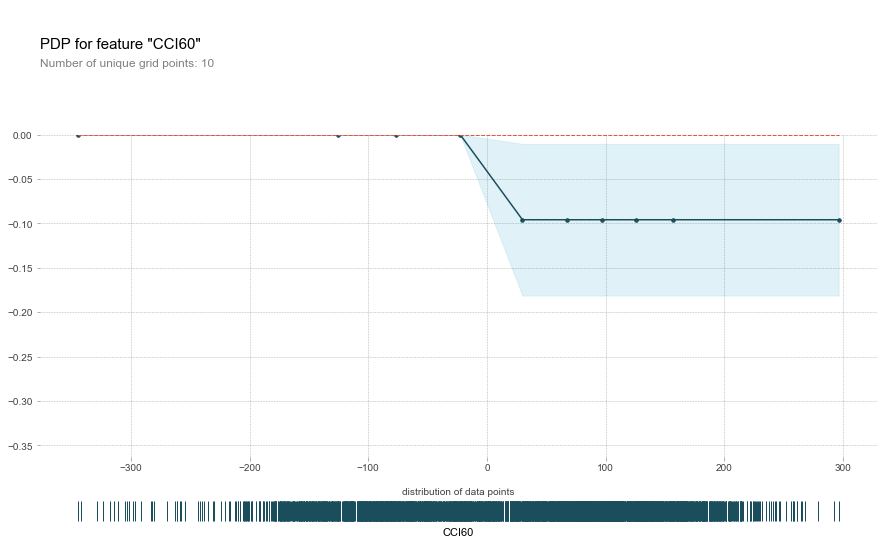

In [16]:
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox import pdp

pdp_gc = pdp.pdp_isolate(
        model = model,
        dataset = df1,
        model_features = X.columns.tolist(),
        feature= 'CCI60'
)

# 플롯 정보 설정
fig, axes = pdp.pdp_plot(
        pdp_gc,
        'CCI60',
        plot_lines = False,
        frac_to_plot = 0.5,
        plot_pts_dist=True
)

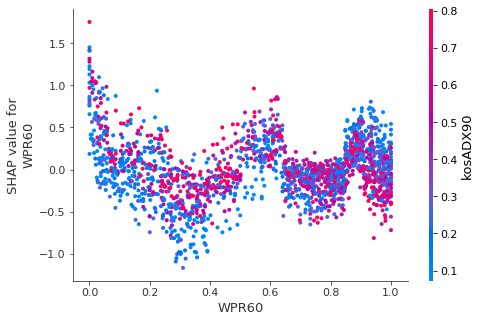

In [17]:
# 하나의 피처가 전체 예측에 미치는 영향력을 SHAP로 계산하고 출력하는 코드
shap.dependence_plot('WPR60', shap_values, X_train,feature_names = X.columns.tolist())

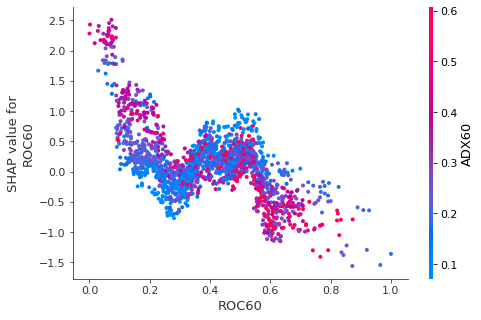

In [18]:
# 하나의 피처가 전체 예측에 미치는 영향력을 SHAP로 계산하고 출력하는 코드
shap.dependence_plot('ROC60', shap_values, X_train,feature_names = X.columns.tolist())

In [19]:
idx = 1500
X_trn = pd.DataFrame(X_train, columns=X.columns)

In [20]:
shap.initjs()

# SHAP 값으로 모델의 예측을 설명하기
# 설명체는 LightGBM, CATBoost, scikit-learn 모델을 입력받을 수 있다.

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

shap.force_plot(explainer.expected_value,
               shap_values[idx,:],
               X_trn.iloc[idx,:])

# 하이퍼 파라미터 튜닝

In [21]:
import numpy as np
from sklearn.model_selection import GridSearchCV

In [22]:
cv_params = {
    'max_depth':[5,6],
    'learning_rate':np.arange(0.05,0.6,0.05),
    'n_estimators':np.arange(10,300,50),
}

fix_params = {
    'booster':'gbtree',
    'objective':'binary:logistic',
}


In [23]:

csv = GridSearchCV(XGBClassifier(**fix_params),
                  cv_params,
                  scoring='accuracy',
                  cv=5,
                  n_jobs = 5)


In [24]:
csv.fit(X_train,y_train)


[20:34:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_...ne,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [25]:

print(csv.best_params_)

{'learning_rate': 0.45, 'max_depth': 5, 'n_estimators': 260}
